In [1]:
import torch
import random
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
!pip install transformers
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader, random_split
seed = 5
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 31.7 MB/s 
     |████████████████████████████████| 6.6 MB 57.4 MB/s 
     |████████████████████████████████| 596 kB 37.5 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
filename = 'drive/MyDrive/pre_main_data.csv'
df = pd.read_csv(filename)
df.tweet = df.tweet.astype(str)
df.head()

,id,label,tweet
0,0,2,! <user> as a woman you should not complain ab...
1,1,1,! <user> boy dats cold tyga dwn bad for cuffin...
2,2,1,! <user> dawg ! <user> you ever fuck a bitch a...
3,3,1,! <user> <user> she look like a tranny
4,4,1,! <user> the shit you hear about me might be t...


# Preprocessing

In [3]:
import re
df['tweet'] = df['tweet'].map(lambda x:
                              x.replace('<user>','').
                              replace('!','').
                              replace('<emotion>','').
                              replace('<number>','').
                              replace('<url>',''))
df['tweet'] = df['tweet'].map(lambda x:
                              re.sub(' +', ' ', x))  #remove extra spaces
df['tweet'] = df['tweet'].map(lambda x:
                              x.lstrip()) #remove spcaces at the begining
del df['id']
df.head()

,label,tweet
0,2,as a woman you should not complain about clean...
1,1,boy dats cold tyga dwn bad for cuffin dat hoe ...
2,1,dawg you ever fuck a bitch and she start to cr...
3,1,she look like a tranny
4,1,the shit you hear about me might be true or it...


**Delete duplicate tweets**

In [4]:
print(df["tweet"].duplicated().sum()) #show number of duplicated tweets
df.drop_duplicates(inplace=True, subset='tweet')
print(df["tweet"].duplicated().sum())
df.head()

153
0


,label,tweet
0,2,as a woman you should not complain about clean...
1,1,boy dats cold tyga dwn bad for cuffin dat hoe ...
2,1,dawg you ever fuck a bitch and she start to cr...
3,1,she look like a tranny
4,1,the shit you hear about me might be true or it...


# Bert

## Creating Dataset

In [ ]:
bert_df = df.copy()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

**Tokenize Dataset**

In [ ]:
bert_df.tweet = bert_df['tweet'].map(lambda x: 
                                     tokenizer(x,
                                               padding="max_length",
                                               truncation=True,
                                               max_length=40,
                                               return_tensors='pt')) # convert to pytorch tensors

In [ ]:
len(df)

24280

In [ ]:
bert_df.head()

,label,tweet
0,2,"[input_ids, token_type_ids, attention_mask]"
1,1,"[input_ids, token_type_ids, attention_mask]"
2,1,"[input_ids, token_type_ids, attention_mask]"
3,1,"[input_ids, token_type_ids, attention_mask]"
4,1,"[input_ids, token_type_ids, attention_mask]"


**Show an example**

In [ ]:
bert_df.tweet[0]

{'input_ids': tensor([[  101,  2004,  1037,  2450,  2017,  2323,  2025, 17612,  2055,  9344,
          2039,  2115,  2160,  1998,  2004,  1037,  2158,  2017,  2323,  2467,
          2202,  1996, 11669,  2041,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

**Define dataset class**

In [ ]:
import torch.nn.functional as F
class TextDataset(Dataset):
  def __init__(self, df):
    self.labels = df['label'].values
    self.text = df['tweet'].values
    self.labels = F.one_hot(torch.from_numpy(self.labels).long()) # convert labels to one-hot
  def __len__(self):
    return len(self.labels)
  def __getitem__(self, idx):
    label = self.labels[idx]
    text = self.text[idx]
    return text, label

### Train-Valid-Test splitting

In [ ]:
total_len = len(bert_df)
training_ratio = 0.75
validation_ratio = 0.10
test_ratio = 0.15
train_len, valid_len, test_len = training_ratio*total_len, validation_ratio*total_len, test_ratio*total_len
train_len, valid_len, test_len = int(train_len), int(valid_len), int(test_len)
print('training len:\t valid len:\t test len:')
print(train_len, '\t\t', valid_len, '\t\t',test_len)

training len:	 valid len:	 test len:
18210 		 2428 		 3642


In [ ]:
TotalData = TextDataset(bert_df)
train, valid = random_split(TotalData, [train_len,total_len-train_len], 
                            generator=torch.Generator().manual_seed(seed))

In [ ]:
valid, test = random_split(valid, [valid_len,len(valid)-valid_len], 
                           generator=torch.Generator().manual_seed(seed))

In [ ]:
print('training len:\t valid len:\t test len:')
print(len(train), '\t\t', len(valid), '\t\t',len(test))

training len:	 valid len:	 test len:
18210 		 2428 		 3642


## Make Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert = BertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
num_classes = len(df.label.unique())

In [ ]:
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
class BERTLSTMnn(nn.Module):
  def __init__(self, bert, seq_len, n_layers):
    super().__init__()
    self.bert = bert
    embedding_size = bert.config.to_dict()['hidden_size']
    self.lstm = nn.LSTM(input_size=embedding_size, 
                        hidden_size=seq_len, 
                        num_layers=n_layers,
                        batch_first=True,
                        dropout=0.2,
                        bidirectional=True)
    self.dense = nn.Linear(seq_len*2, num_classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, sentence):
    with torch.no_grad():
      embedded = self.bert(input_ids=sentence['input_ids'].squeeze(1),
                           attention_mask=sentence['attention_mask'])
      
    _, (HiddenStates, CellStates) = self.lstm(embedded['last_hidden_state'])

    output = self.dense(torch.cat((HiddenStates[0], HiddenStates[1]), dim = 1))
    output = self.softmax(output)
    return output

In [ ]:
bert_df.tweet[0]['input_ids'].size()  #need squeeze!

torch.Size([1, 40])

**Function for evaluating accuracy and loss of input**

In [5]:
def evaluate(model, data, batch_size, criterion):
  dataloader = DataLoader(data, batch_size, shuffle=True)
  error = 0
  loss = 0
  model.eval()
  for batch in dataloader:
    batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
    with torch.no_grad():
      prediction = model(batch[0]).to(device) 
    loss += criterion(prediction, batch[1].float()).item()
    prediction = prediction.argmax(axis=1).cpu().numpy()
    target = batch[1].argmax(axis=1).cpu().numpy()
    error += np.sum(np.abs(target - prediction))

  accuracy = 1 - error/len(data)
  loss = loss/len(dataloader)
  return accuracy, loss

**Function for doing a single epoch**

In [6]:
def fit(model, train_dataset, batch_size, optimizer, criterion):
  data_len = len(train_dataset)
  train_loss = 0
  error = 0
  model.train()
  train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True) # shuffle for fitting
  for i, batch in enumerate(train_dataloader):
    print(f'\rbatch {i+1}/{len(train_dataloader)} - training loss = {train_loss / (i+1)}', end='')
    optimizer.zero_grad()
    predictions = model(batch[0].to(device)).squeeze(1)
    loss = criterion(predictions, batch[1].to(device).float())
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    predictions = predictions.argmax(axis=1).cpu().numpy()
    targets = batch[1].argmax(axis=1).cpu().numpy()
    error += np.sum(np.abs(targets - predictions))
  return  1 - error/len(train_dataset), train_loss/len(train_dataloader) # return accuracy and loss

**Function for predicting output**

In [7]:
def predict(model, input, batch_size):
  dataloader = DataLoader(input, batch_size, shuffle=False) # don't shuffle for prediction
  output = np.empty((0,num_classes))
  targets = np.empty((0,num_classes))
  for batch in dataloader:
    model.eval()
    with torch.no_grad():
      prediction = model(batch[0].to(device)).cpu()
    prediction = prediction.detach().numpy()
    output = np.vstack([output, prediction])
    target = batch[1].cpu().numpy()
    targets = np.vstack([targets, target])
  return output, targets

### Create Model Instance

In [ ]:
seq_len = 32
layers = 16
model = BERTLSTMnn(bert, seq_len, layers)
for name, param in model.named_parameters():
    if name.startswith('bert'):
        param.requires_grad = False

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

## Start Training Model

epoch 1/12
batch 570/570 - training loss = 0.7271243971690797 training accuracy = 0.8200988467874795  validation loss = 0.6902669417230707  validation accuracy 0.8496705107084019
epoch 2/12
batch 570/570 - training loss = 0.6794288579832044 training accuracy = 0.8611751784733663  validation loss = 0.6859047397186882  validation accuracy 0.8612026359143328
epoch 3/12
batch 570/570 - training loss = 0.666375670307561 training accuracy = 0.8751784733662823  validation loss = 0.661907188986477  validation accuracy 0.8826194398682042
epoch 4/12
batch 570/570 - training loss = 0.6585186342398326 training accuracy = 0.8827567270730368  validation loss = 0.6586733460426331  validation accuracy 0.8838550247116969
epoch 5/12
batch 570/570 - training loss = 0.6525679301797298 training accuracy = 0.8891268533772653  validation loss = 0.6490756100729892  validation accuracy 0.8920922570016474
epoch 6/12
batch 570/570 - training loss = 0.648839060883773 training accuracy = 0.8912136188907194  valida

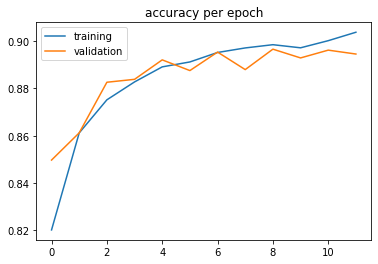

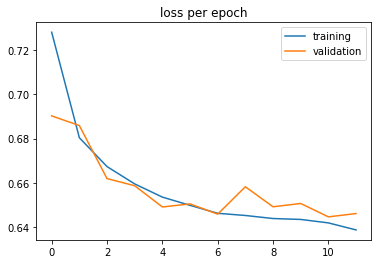

In [ ]:
import matplotlib.pyplot as plt

batch_size = 32
epochs = 12
accuracy_history = np.zeros((epochs, 2))
loss_history = np.zeros((epochs, 2))
for epoch in range(epochs):
  print(f'epoch {epoch+1}/{epochs}')
  accuracy_history[epoch,0] , loss_history[epoch,0] = fit(model, train, batch_size, optimizer, criterion)
  accuracy_history[epoch,1] , loss_history[epoch,1] = evaluate(model, valid, batch_size, criterion)
  print(' training accuracy =', accuracy_history[epoch,0], 
        ' validation loss ='  , loss_history[epoch,1], 
        ' validation accuracy', accuracy_history[epoch,1])
plt.plot(accuracy_history[:,0])
plt.plot(accuracy_history[:,1])
plt.title('accuracy per epoch')
plt.legend(['training', 'validation'])
plt.show()
plt.figure()
plt.plot(loss_history[:,0])
plt.plot(loss_history[:,1])
plt.title('loss per epoch')
plt.legend(['training', 'validation'])
plt.show()

## Display Results

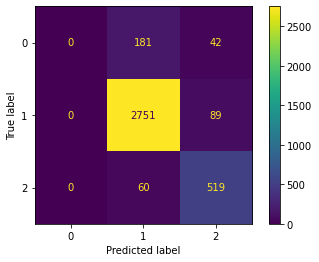

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions, targets = predict(model, test, 128)
predictions, targets = predictions.argmax(axis=1), targets.argmax(axis=1)
cm = confusion_matrix(targets, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(targets, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       223
           1       0.92      0.97      0.94      2840
           2       0.80      0.90      0.84       579

    accuracy                           0.90      3642
   macro avg       0.57      0.62      0.60      3642
weighted avg       0.84      0.90      0.87      3642



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
